In [21]:
import cv2
import math
import csv
import os
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import ultralytics
import sam2 as sam
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from ultralytics.solutions.solutions import BaseSolution
from ultralytics.utils.plotting import Annotator, colors
from datetime import datetime
%matplotlib inline

In [22]:
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# Verifica si TensorFlow detecta la GPU
if tf.config.list_physical_devices('GPU'):
    print("¡GPU encontrada!")
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("¡GPU no encontrada!")

¡GPU encontrada!
Num GPUs Available:  1


https://www.digitalocean.com/community/tutorials/what-is-new-with-yolo

## EJERCICIO 1 
Vamos a usar el modleo YOLOv11 para detectar objetos en una imagen (en este caso vamos a aplicar el modelo directamente sin entrenarlo).
Vamos a aplicarlo en las imagenes deteccion_objetos.jpg y bus.jpg

Partiendo de la imagen deteccion_objetos.jpg y bus.jpg.



In [3]:
ruta_imgs = 'datos/imagenes/'
imgs_arr = [ruta_imgs+"deteccion_objetos.jpg",ruta_imgs+"bus.jpg"]
# cargar modelo yolo11
model = ultralytics.YOLO("recursos/5_5/yolo/yolo11n.pt")   

results = model(imgs_arr)
for res in results:
    res.show()


0: 640x640 11 persons, 7 bicycles, 4 cars, 2 fire hydrants, 16.5ms
1: 640x640 4 persons, 1 bus, 16.5ms
Speed: 3.8ms preprocess, 16.5ms inference, 43.9ms postprocess per image at shape (1, 3, 640, 640)


## EJERCICIO 2
Vamos a repetir el ejercicio pero ahora vamos a modificar la salida para que quede de la siguiente forma:

![Imagen con la el resultado que se quiere obtener 1](datos/imagenes//deteccion_objetos_solucion.png)

![Imagen con la el resultado que se quiere obtener 1](datos/imagenes//bus_solucion.png)

Además sólo quiero que detecte los objetos cuya probabilidad sea mayor al 50%.

Ten en cuenta que al aplicar el modelo a una imagen devuelve diferentes datos:
 * Cajas:
    * Clase (cls)
    * Probabilidad (score)
    * Coordenadas de la caja xyxy

Para representar la imagen y añadir rectángulos, texto... puedes usar Image, ImageDraw, ImageFont de PIL. Dibujas la imagen con .Draw de (ImageDraw) con .rectangle y .text puedes ir añadiendo texto y rectángulos.

In [4]:
clases = results[0].names
colores = ['cyan','orange','pink','green','yellow','red','blue','white']
guia = {}

0
1
2


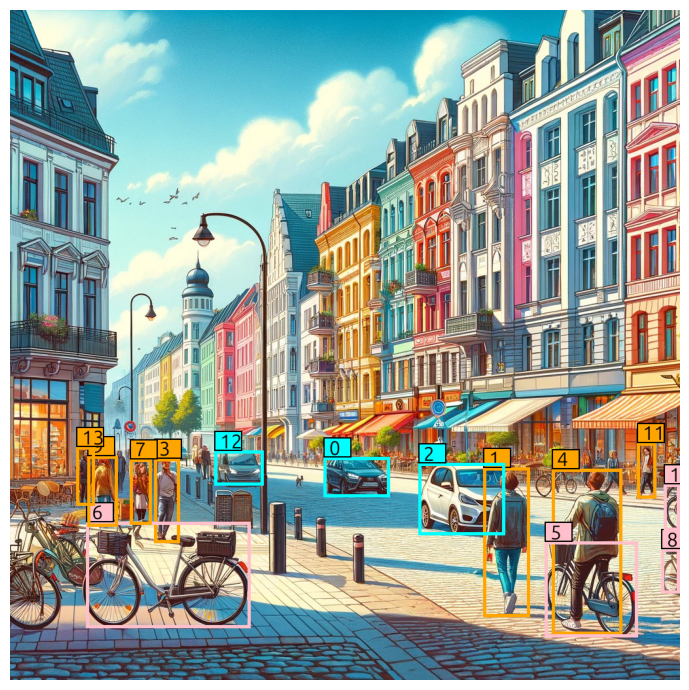

Elemento 0--> Clase: car,	 Probabilidad: 0.8778764605522156,	 Coordenadas: tensor([479.8883, 683.6398, 580.6799, 744.2516], device='cuda:0')
Elemento 1--> Clase: person,	 Probabilidad: 0.8711369633674622,	 Coordenadas: tensor([723.8831, 699.6281, 794.2302, 927.2527], device='cuda:0')
Elemento 2--> Clase: car,	 Probabilidad: 0.8497547507286072,	 Coordenadas: tensor([624.3212, 692.6537, 756.9240, 802.4709], device='cuda:0')
Elemento 3--> Clase: person,	 Probabilidad: 0.8445959687232971,	 Coordenadas: tensor([220.4718, 685.4314, 259.8442, 814.4322], device='cuda:0')
Elemento 4--> Clase: person,	 Probabilidad: 0.8234404921531677,	 Coordenadas: tensor([828.3610, 701.1053, 935.8299, 954.4529], device='cuda:0')
Elemento 5--> Clase: bicycle,	 Probabilidad: 0.7793213725090027,	 Coordenadas: tensor([817.9751, 812.5693, 959.1559, 958.2740], device='cuda:0')
Elemento 6--> Clase: bicycle,	 Probabilidad: 0.7656781673431396,	 Coordenadas: tensor([116.6321, 782.1196, 367.2387, 944.4985], device='cuda:

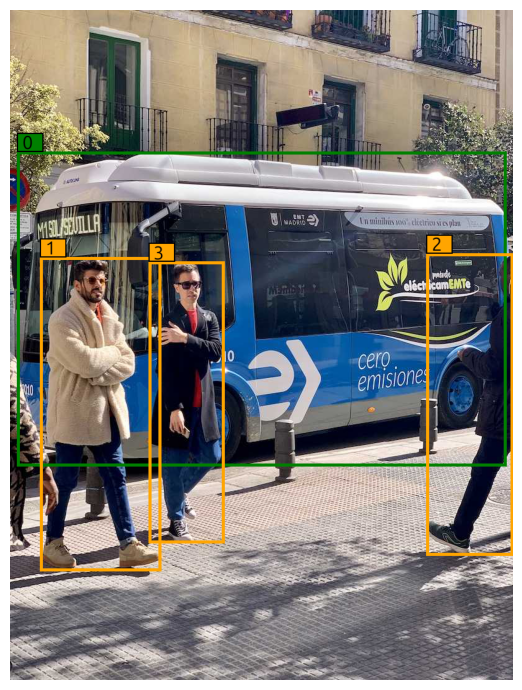

Elemento 0--> Clase: bus,	 Probabilidad: 0.9391075372695923,	 Coordenadas: tensor([ 11.9472, 228.3151, 799.1895, 735.3087], device='cuda:0')
Elemento 1--> Clase: person,	 Probabilidad: 0.9017204642295837,	 Coordenadas: tensor([ 48.6464, 398.2117, 243.0680, 904.5064], device='cuda:0')
Elemento 2--> Clase: person,	 Probabilidad: 0.8498591780662537,	 Coordenadas: tensor([670.6041, 392.3168, 810.0000, 879.6082], device='cuda:0')
Elemento 3--> Clase: person,	 Probabilidad: 0.8376365900039673,	 Coordenadas: tensor([223.0595, 405.5998, 345.2839, 859.7147], device='cuda:0')



In [5]:
for idx,res in enumerate(results, start=0):    
    boxes = res.boxes  # Boxes object for bounding box outputs
    txt = ''
    filtrados = []
    for jdx,(cls,prob,coords) in enumerate(zip(boxes.cls,boxes.conf,boxes.xyxy)):
        if prob > 0.5:      # probabilidad mayor del 50%            
            # datos prediccion
            filtrados.append([cls,prob,coords])
            txt += 'Elemento {}--> Clase: {},\t Probabilidad: {},\t Coordenadas: {}\n'.format(jdx, clases[int(cls)], prob, coords)
            if int(cls) not in guia.keys(): 
                print(len(guia.keys()))
                guia[int(cls)] = colores[len(guia.keys())]
    # imagen
    img = Image.open(imgs_arr[idx])
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf", size=30)

    for i,caso in enumerate(filtrados):
        coords = caso[2]
        color = guia[int(caso[0])]
        draw.rectangle([coords[0], coords[1], coords[2], coords[3]], outline=color, width=5)
        draw.rectangle([coords[0], coords[1]-30, coords[0]+2 + 40, coords[1]],fill="black")
        draw.rectangle([coords[0]+2, coords[1]-28, coords[0] + 40, coords[1]-2],fill=color)
        draw.text((coords[0]+8, coords[1]-32), str(i), fill="black",font=font)

    # mostrar resultados
    plt.figure(figsize=(13,7))
    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    print(txt)

## EJERCICIO 3
YOLOv11 también sirve para segmentación, aplica segmentación a las dos imágenes con las que estamos trabajando

In [6]:
model = ultralytics.YOLO('recursos/5_5/yolo/yolo11n-seg.pt')  

ruta_imgs = 'datos/imagenes/'
imgs_arr = [ruta_imgs+"deteccion_objetos.jpg",ruta_imgs+"bus.jpg"]


for img in imgs_arr:
    results = model(img)  
    results[0].show()



image 1/1 /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/imagenes/deteccion_objetos.jpg: 640x640 11 persons, 8 bicycles, 3 cars, 1 backpack, 5.1ms
Speed: 1.7ms preprocess, 5.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/imagenes/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 46.6ms
Speed: 1.3ms preprocess, 46.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


## EJERCICIO 4
De manera similar, podemos hacer la estimación de pose. Hazlo con las imágenes con las que estamos trabajando.

In [7]:
model = ultralytics.YOLO('recursos/5_5/yolo/yolo11n-pose.pt')  

ruta_imgs = 'datos/imagenes/'
imgs_arr = [ruta_imgs+"deteccion_objetos.jpg",ruta_imgs+"bus.jpg"]


for img in imgs_arr:
    results = model(img)  
    results[0].show()



image 1/1 /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/imagenes/deteccion_objetos.jpg: 640x640 2 persons, 5.2ms
Speed: 1.8ms preprocess, 5.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/imagenes/bus.jpg: 640x480 4 persons, 14.3ms
Speed: 1.3ms preprocess, 14.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


## EJERCICIO 5
Haz lo que se hace en el siguiente video:

https://www.youtube.com/watch?v=_YbEna8UNcU

Tienes parte del código en:

https://www.albertcoronado.com/2024/11/12/tutorial-yolo-11/

Para la parte fine tuning tienes que entrenar el modelo para que distina matrículas de coche, para entrenar el modelo utiliza el dataset que puedes descargar de:

https://universe.roboflow.com/parag-parmar-3qpin/car_license_plate-ypwmk/dataset/1

NOTA: HE CONSEGUIDO QUE FUNCIONE BIEN CV2 PERO ABRIENDO PRIMERO UNA IMAGEN:
```
img = cv2.imread('Datos/image3.jpg')
cv2.imshow("SAPA", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
```

In [12]:
# camara
model = YOLO("recursos/5_5/yolo/yolo11x.pt")
cap = cv2.VideoCapture(0)

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.7
color = (0, 250, 0)
thickness = 2

while True:
    success, img = cap.read()
    results = model( img, stream=True )

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            confidence = math.ceil((box.conf[0]*100))
            
            cv2.rectangle(img, ( x1, y1 ), ( x2, y2 ), color, 1)
            cv2.putText(img, r.names[ int( box.cls[0] ) ]+" "+str(confidence)+"%", [ x1+4, y1+25 ], font, fontScale, color, thickness)

    cv2.imshow('Webcam', img)

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@245.220] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created



0: 480x640 1 person, 1 backpack, 1 bottle, 3 chairs, 2 dining tables, 1 tv, 19.2ms
Speed: 0.9ms preprocess, 19.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 1 bottle, 2 chairs, 2 dining tables, 1 tv, 18.7ms
Speed: 1.0ms preprocess, 18.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 1 bottle, 3 chairs, 2 dining tables, 1 tv, 18.8ms
Speed: 0.9ms preprocess, 18.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 1 bottle, 2 chairs, 2 dining tables, 1 tv, 18.8ms
Speed: 1.1ms preprocess, 18.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 1 bottle, 3 chairs, 2 dining tables, 1 tv, 18.7ms
Speed: 0.9ms preprocess, 18.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 backpack, 1 bottle, 2 chairs, 2 dining tables, 1 tv, 13.8ms
Speed: 1.1m

In [13]:
#segmentation 
model = ultralytics.YOLO('recursos/5_5/yolo/fine_tunning.pt')  

img='datos/imagenes/matricula.jpg'


results = model(img)  
results[0].show()



image 1/1 /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/imagenes/matricula.jpg: 480x640 1 licence, 31.9ms
Speed: 1.1ms preprocess, 31.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


## EJERCICIO 6
Repite el fine tuning del apartado anterior pero ahora en vez de como un comando en la terminal con código de python

In [3]:
# Load a model  
model = ultralytics.YOLO("recursos/5_5/yolo/yolo11s.pt")

# Train the model  
model.train(data="datos/datasets/matriculas_yolo/data.yaml", #path to yaml file  
           imgsz=400, #image size for training  
           batch=10, #number of batch size  
           epochs=100, #number of epochs  
           device=0) #device ‘0’ if gpu else ‘cpu’


New https://pypi.org/project/ultralytics/8.3.74 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.70 🚀 Python-3.12.8 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4080 Laptop GPU, 12003MiB)
engine/trainer: task=detect, mode=train, model=recursos/5_5/yolo/yolo11s.pt, data=datos/datasets/matriculas_yolo/data.yaml, epochs=100, time=None, patience=100, batch=10, imgsz=400, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, 

100%|██████████| 5.35M/5.35M [00:00<00:00, 22.9MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[400] must be multiple of max stride 32, updating to [416]


train: Scanning /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/datasets/matriculas_yolo/train/labels.cache... 210 images, 0 backgrounds, 0 corrupt: 100%|██████████| 210/210 [00:00<?, ?it/s]
val: Scanning /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/datasets/matriculas_yolo/valid/labels.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]


Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00046875), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train8
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.41G      1.934      5.389      1.529         22        416: 100%|██████████| 21/21 [00:01<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.09it/s]

                   all         60         64      0.544      0.453      0.475      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.34G      1.757      2.085      1.263         24        416: 100%|██████████| 21/21 [00:01<00:00, 20.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 19.46it/s]

                   all         60         64      0.464      0.609      0.476      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.35G      1.746      1.815      1.335         15        416: 100%|██████████| 21/21 [00:01<00:00, 19.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 19.99it/s]

                   all         60         64     0.0452      0.641     0.0401     0.0178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.35G      1.763      1.599      1.383         16        416: 100%|██████████| 21/21 [00:01<00:00, 20.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.06it/s]


                   all         60         64     0.0322      0.562     0.0253    0.00979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.34G       1.72      1.485        1.3         24        416: 100%|██████████| 21/21 [00:00<00:00, 21.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.37it/s]

                   all         60         64     0.0104      0.444    0.00767     0.0035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.35G      1.782      1.515      1.387         15        416: 100%|██████████| 21/21 [00:00<00:00, 21.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.61it/s]

                   all         60         64    0.00481      0.391    0.00326     0.0013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.35G      1.723      1.579      1.308         24        416: 100%|██████████| 21/21 [00:00<00:00, 21.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.10it/s]

                   all         60         64     0.0015      0.422    0.00121    0.00036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.35G      1.675      1.348      1.311         23        416: 100%|██████████| 21/21 [00:01<00:00, 20.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.55it/s]

                   all         60         64   0.000922      0.141   0.000534   0.000218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.35G      1.697      1.289      1.275         24        416: 100%|██████████| 21/21 [00:00<00:00, 21.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.32it/s]

                   all         60         64   0.000913     0.0781    0.00051   0.000101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.35G      1.709      1.247      1.355         30        416: 100%|██████████| 21/21 [00:00<00:00, 21.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.01it/s]

                   all         60         64      0.414      0.328       0.25      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.35G      1.623      1.194      1.288         21        416: 100%|██████████| 21/21 [00:00<00:00, 21.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.16it/s]

                   all         60         64       0.63      0.281      0.275      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.35G       1.62       1.15      1.308         23        416: 100%|██████████| 21/21 [00:00<00:00, 21.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.81it/s]

                   all         60         64      0.215      0.484      0.144     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.34G       1.63      1.217       1.31         30        416: 100%|██████████| 21/21 [00:00<00:00, 21.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.30it/s]

                   all         60         64       0.46      0.422      0.355      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.35G      1.639      1.214      1.301         17        416: 100%|██████████| 21/21 [00:00<00:00, 21.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.06it/s]

                   all         60         64      0.629      0.477      0.541      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.35G      1.622      1.192       1.31         24        416: 100%|██████████| 21/21 [00:00<00:00, 21.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.55it/s]

                   all         60         64      0.432      0.666      0.523      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.34G      1.559      1.059      1.261         23        416: 100%|██████████| 21/21 [00:00<00:00, 21.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 20.87it/s]

                   all         60         64      0.261      0.516      0.251      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.35G      1.545      1.121       1.28         16        416: 100%|██████████| 21/21 [00:00<00:00, 21.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.14it/s]

                   all         60         64      0.621      0.691      0.648      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.34G      1.572      1.085      1.274         26        416: 100%|██████████| 21/21 [00:00<00:00, 21.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.26it/s]

                   all         60         64      0.788      0.641      0.758      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.34G      1.529      1.072      1.261         16        416: 100%|██████████| 21/21 [00:00<00:00, 21.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.18it/s]

                   all         60         64      0.715      0.688       0.72      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.34G      1.494      1.027      1.218         18        416: 100%|██████████| 21/21 [00:00<00:00, 21.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.98it/s]

                   all         60         64      0.611      0.641      0.603      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.34G      1.559      1.116      1.247         17        416: 100%|██████████| 21/21 [00:00<00:00, 21.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.00it/s]

                   all         60         64      0.642      0.646      0.629      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.34G      1.535      1.011      1.254         21        416: 100%|██████████| 21/21 [00:01<00:00, 20.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.88it/s]

                   all         60         64      0.705      0.656      0.664      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.35G      1.576      1.051      1.249         16        416: 100%|██████████| 21/21 [00:00<00:00, 21.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.67it/s]

                   all         60         64      0.698      0.651       0.68      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.35G      1.595      1.045      1.246         24        416: 100%|██████████| 21/21 [00:01<00:00, 20.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.27it/s]

                   all         60         64      0.759      0.625      0.686      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.34G      1.446     0.9809      1.247         21        416: 100%|██████████| 21/21 [00:00<00:00, 21.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.99it/s]

                   all         60         64      0.623      0.672      0.636      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.34G      1.536       1.06      1.284         15        416: 100%|██████████| 21/21 [00:00<00:00, 21.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.36it/s]

                   all         60         64      0.765      0.594       0.74       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.35G      1.529      1.045      1.266         32        416: 100%|██████████| 21/21 [00:00<00:00, 21.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.53it/s]

                   all         60         64      0.676      0.751        0.7       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.34G      1.397     0.9736      1.178         22        416: 100%|██████████| 21/21 [00:01<00:00, 20.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.03it/s]

                   all         60         64      0.774      0.749      0.749      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.34G      1.387     0.9134      1.186         22        416: 100%|██████████| 21/21 [00:00<00:00, 21.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.16it/s]

                   all         60         64      0.668      0.703      0.723      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.34G        1.4     0.9526      1.201         13        416: 100%|██████████| 21/21 [00:00<00:00, 21.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.36it/s]

                   all         60         64      0.817        0.7      0.724      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.34G      1.393     0.8888      1.145         23        416: 100%|██████████| 21/21 [00:01<00:00, 20.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.83it/s]

                   all         60         64      0.726      0.747       0.76      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.34G      1.354     0.8758      1.191         19        416: 100%|██████████| 21/21 [00:00<00:00, 21.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.69it/s]

                   all         60         64      0.693      0.813        0.8      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.34G      1.383     0.9412      1.187         24        416: 100%|██████████| 21/21 [00:00<00:00, 21.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.78it/s]

                   all         60         64      0.808      0.734      0.829      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.34G      1.335     0.8989      1.162         20        416: 100%|██████████| 21/21 [00:01<00:00, 20.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.52it/s]

                   all         60         64      0.787      0.719      0.802      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.34G      1.288     0.8475      1.153         28        416: 100%|██████████| 21/21 [00:00<00:00, 22.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.03it/s]

                   all         60         64      0.816      0.833      0.863      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.34G      1.309     0.8232      1.174         28        416: 100%|██████████| 21/21 [00:00<00:00, 21.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.81it/s]

                   all         60         64      0.924      0.765      0.869      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.34G      1.432     0.8583      1.195         29        416: 100%|██████████| 21/21 [00:00<00:00, 21.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.25it/s]

                   all         60         64      0.791      0.797      0.823      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.34G      1.341     0.8647      1.201         25        416: 100%|██████████| 21/21 [00:00<00:00, 21.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.11it/s]

                   all         60         64      0.699      0.799      0.789      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.34G      1.284     0.8305      1.111         26        416: 100%|██████████| 21/21 [00:00<00:00, 21.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.57it/s]

                   all         60         64      0.865      0.688      0.793      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.34G      1.324     0.8434       1.19         14        416: 100%|██████████| 21/21 [00:01<00:00, 20.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.25it/s]

                   all         60         64      0.788      0.766      0.809      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.34G      1.319     0.8153      1.125         25        416: 100%|██████████| 21/21 [00:00<00:00, 21.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.53it/s]

                   all         60         64      0.819      0.778      0.844      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.34G      1.232     0.7844      1.119         17        416: 100%|██████████| 21/21 [00:00<00:00, 21.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.14it/s]

                   all         60         64      0.797      0.859      0.854      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.34G      1.336     0.8063      1.153         19        416: 100%|██████████| 21/21 [00:00<00:00, 21.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.18it/s]

                   all         60         64      0.898      0.823      0.867      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.35G       1.26     0.8157      1.148         25        416: 100%|██████████| 21/21 [00:00<00:00, 21.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.39it/s]

                   all         60         64       0.87       0.73      0.809      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.34G      1.284     0.8294      1.104         16        416: 100%|██████████| 21/21 [00:00<00:00, 21.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.58it/s]

                   all         60         64      0.672      0.812      0.759      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.34G      1.238     0.7739      1.112         22        416: 100%|██████████| 21/21 [00:01<00:00, 20.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 19.69it/s]

                   all         60         64      0.836      0.794      0.803      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.34G      1.217     0.7571      1.103         19        416: 100%|██████████| 21/21 [00:00<00:00, 21.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.94it/s]

                   all         60         64      0.871      0.797      0.851      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.34G      1.201     0.7317      1.094         23        416: 100%|██████████| 21/21 [00:00<00:00, 21.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.95it/s]

                   all         60         64      0.811      0.812      0.848      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.34G      1.251     0.7448      1.116         15        416: 100%|██████████| 21/21 [00:01<00:00, 20.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.19it/s]

                   all         60         64      0.901      0.853      0.887      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.34G      1.266     0.7285      1.135         23        416: 100%|██████████| 21/21 [00:00<00:00, 21.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.48it/s]

                   all         60         64      0.849      0.797      0.863      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.34G      1.205     0.7151        1.1         21        416: 100%|██████████| 21/21 [00:00<00:00, 21.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.15it/s]

                   all         60         64       0.86      0.734      0.834      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.34G      1.214     0.7253      1.088         17        416: 100%|██████████| 21/21 [00:00<00:00, 21.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.43it/s]

                   all         60         64      0.822      0.797      0.845      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.35G      1.177     0.7284      1.116         25        416: 100%|██████████| 21/21 [00:00<00:00, 21.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.65it/s]

                   all         60         64      0.789      0.819      0.864      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.35G      1.197     0.7269      1.104         26        416: 100%|██████████| 21/21 [00:00<00:00, 21.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.81it/s]

                   all         60         64      0.843      0.838      0.851      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.34G      1.145     0.7216      1.085         25        416: 100%|██████████| 21/21 [00:00<00:00, 21.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.42it/s]

                   all         60         64      0.927      0.796      0.855      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.34G      1.144     0.6894      1.072         19        416: 100%|██████████| 21/21 [00:00<00:00, 21.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.81it/s]

                   all         60         64      0.859      0.766      0.813      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.34G      1.172     0.6726      1.076         27        416: 100%|██████████| 21/21 [00:00<00:00, 21.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.42it/s]

                   all         60         64      0.874      0.766      0.815      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.34G      1.134     0.6797      1.061         26        416: 100%|██████████| 21/21 [00:01<00:00, 20.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.17it/s]

                   all         60         64      0.903      0.729       0.83      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.34G      1.125     0.6756      1.058         27        416: 100%|██████████| 21/21 [00:00<00:00, 21.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.75it/s]

                   all         60         64      0.841      0.828      0.862      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.34G      1.112     0.6496      1.072         19        416: 100%|██████████| 21/21 [00:00<00:00, 21.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.92it/s]

                   all         60         64      0.832      0.844      0.862      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.34G      1.162     0.6855      1.077         18        416: 100%|██████████| 21/21 [00:00<00:00, 21.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.98it/s]

                   all         60         64      0.868      0.781      0.854       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.34G      1.113     0.6866      1.086         26        416: 100%|██████████| 21/21 [00:01<00:00, 20.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.62it/s]

                   all         60         64      0.781      0.766      0.812      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.34G       1.08     0.6317      1.047         24        416: 100%|██████████| 21/21 [00:00<00:00, 21.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.72it/s]

                   all         60         64      0.794      0.662      0.752      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.34G      1.139     0.6624       1.06         24        416: 100%|██████████| 21/21 [00:00<00:00, 21.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.54it/s]

                   all         60         64      0.763      0.755       0.81      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.34G       1.12     0.6522      1.098         27        416: 100%|██████████| 21/21 [00:00<00:00, 21.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.09it/s]

                   all         60         64      0.759      0.781      0.796      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.34G      1.125     0.7071      1.059         21        416: 100%|██████████| 21/21 [00:01<00:00, 20.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.57it/s]

                   all         60         64      0.804      0.781      0.846      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.34G      1.049     0.6402      1.055         23        416: 100%|██████████| 21/21 [00:00<00:00, 21.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.38it/s]

                   all         60         64      0.857      0.746      0.862      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.34G      1.087      0.612      1.068         19        416: 100%|██████████| 21/21 [00:01<00:00, 20.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.85it/s]

                   all         60         64      0.813      0.828      0.875      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.34G      1.042     0.6108      1.035         24        416: 100%|██████████| 21/21 [00:00<00:00, 21.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.34it/s]

                   all         60         64      0.797      0.738      0.815      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.34G      1.043     0.6041      1.036         15        416: 100%|██████████| 21/21 [00:01<00:00, 20.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.15it/s]

                   all         60         64      0.833      0.734      0.834      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.34G      1.054     0.6054      1.033         18        416: 100%|██████████| 21/21 [00:00<00:00, 21.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.75it/s]

                   all         60         64      0.879      0.766      0.861      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.34G      1.026     0.5958      1.046         22        416: 100%|██████████| 21/21 [00:00<00:00, 21.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.00it/s]

                   all         60         64      0.868      0.819      0.857      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.34G      1.026     0.6244      1.048         17        416: 100%|██████████| 21/21 [00:00<00:00, 21.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.70it/s]

                   all         60         64      0.858      0.859      0.869      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.34G     0.9695     0.5822       1.01         16        416: 100%|██████████| 21/21 [00:00<00:00, 21.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.57it/s]

                   all         60         64      0.859      0.766      0.808       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.34G      1.056     0.6324      1.018         21        416: 100%|██████████| 21/21 [00:00<00:00, 21.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.48it/s]

                   all         60         64      0.811      0.812      0.811      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.34G      1.082      0.625      1.036         17        416: 100%|██████████| 21/21 [00:00<00:00, 21.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.98it/s]

                   all         60         64      0.795      0.844      0.819      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.34G      0.983     0.5827     0.9945         15        416: 100%|██████████| 21/21 [00:00<00:00, 21.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.44it/s]

                   all         60         64      0.853      0.859      0.878      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.34G     0.9954     0.5883      1.005         28        416: 100%|██████████| 21/21 [00:00<00:00, 21.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.67it/s]

                   all         60         64      0.935      0.812      0.868      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.34G     0.9916     0.6183     0.9996         23        416: 100%|██████████| 21/21 [00:00<00:00, 21.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.43it/s]

                   all         60         64       0.85      0.828      0.847      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.34G     0.9626     0.5916      1.012         20        416: 100%|██████████| 21/21 [00:00<00:00, 21.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.68it/s]

                   all         60         64      0.835      0.812      0.836      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.34G     0.9821     0.5552     0.9967         29        416: 100%|██████████| 21/21 [00:00<00:00, 21.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.69it/s]

                   all         60         64      0.814      0.821      0.834      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.35G     0.9263     0.5432     0.9671         32        416: 100%|██████████| 21/21 [00:00<00:00, 21.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.95it/s]

                   all         60         64       0.85      0.797       0.84      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.34G     0.9162     0.5393      1.011         22        416: 100%|██████████| 21/21 [00:00<00:00, 21.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.64it/s]

                   all         60         64      0.866      0.809      0.845      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.34G     0.9125     0.5218     0.9825         20        416: 100%|██████████| 21/21 [00:00<00:00, 21.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.43it/s]

                   all         60         64      0.873      0.862      0.873      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.34G     0.8718     0.5437     0.9733         28        416: 100%|██████████| 21/21 [00:01<00:00, 20.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.49it/s]

                   all         60         64      0.882      0.817       0.85      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.34G      0.935     0.5506     0.9686         24        416: 100%|██████████| 21/21 [00:00<00:00, 21.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.49it/s]

                   all         60         64      0.847      0.844      0.863      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.35G     0.8994     0.5277     0.9778         22        416: 100%|██████████| 21/21 [00:00<00:00, 21.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.38it/s]

                   all         60         64      0.876      0.883      0.883      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.34G      0.921     0.5395     0.9907         20        416: 100%|██████████| 21/21 [00:00<00:00, 21.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.56it/s]

                   all         60         64      0.899      0.859      0.877      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.34G      0.882      0.506     0.9809         22        416: 100%|██████████| 21/21 [00:00<00:00, 21.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.69it/s]

                   all         60         64        0.9      0.844      0.883      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.35G     0.8726     0.5167     0.9543         21        416: 100%|██████████| 21/21 [00:01<00:00, 20.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.42it/s]

                   all         60         64      0.873      0.856      0.874      0.469


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.34G     0.8888     0.5283      1.011         10        416: 100%|██████████| 21/21 [00:01<00:00, 19.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.91it/s]

                   all         60         64       0.85      0.844      0.879      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.34G     0.9056       0.53     0.9734          9        416: 100%|██████████| 21/21 [00:01<00:00, 20.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.50it/s]

                   all         60         64      0.843      0.838      0.867      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.34G     0.8536     0.5016     0.9738         15        416: 100%|██████████| 21/21 [00:00<00:00, 21.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.80it/s]

                   all         60         64      0.824      0.805      0.831      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.34G     0.8326     0.4863     0.9266         11        416: 100%|██████████| 21/21 [00:00<00:00, 21.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 21.04it/s]

                   all         60         64      0.833      0.782      0.829      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.34G      0.803     0.4889     0.9522         11        416: 100%|██████████| 21/21 [00:01<00:00, 20.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.83it/s]

                   all         60         64      0.831      0.828      0.851      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.34G     0.7954     0.4757     0.9226         10        416: 100%|██████████| 21/21 [00:01<00:00, 20.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 22.70it/s]

                   all         60         64      0.862      0.812       0.86       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.34G     0.7867     0.4753     0.9324         10        416: 100%|██████████| 21/21 [00:01<00:00, 20.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.14it/s]

                   all         60         64      0.912      0.808      0.869       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.34G     0.8031      0.465     0.9448         13        416: 100%|██████████| 21/21 [00:00<00:00, 21.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.66it/s]

                   all         60         64      0.884      0.812      0.872      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.34G     0.8105     0.4922     0.9621         12        416: 100%|██████████| 21/21 [00:00<00:00, 21.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.25it/s]

                   all         60         64      0.882      0.812      0.876      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.34G     0.8031      0.462     0.9431         10        416: 100%|██████████| 21/21 [00:00<00:00, 21.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 23.93it/s]

                   all         60         64      0.883      0.859      0.876      0.472



100 epochs completed in 0.044 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 19.2MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.12.8 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4080 Laptop GPU, 12003MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 13.48it/s]


                   all         60         64      0.866      0.809      0.845      0.487
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7256b690f680>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [4]:
model = ultralytics.YOLO('runs/detect/train5/weights/best.pt')  

img='datos/imagenes/matricula.jpg'


results = model(img)  
results[0].show()



image 1/1 /home/iabd/IABD_2425/Python_Ejers/SAPA/Deep_Learning/Ejercicios/datos/imagenes/matricula.jpg: 320x416 1 licence, 34.7ms
Speed: 0.5ms preprocess, 34.7ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 416)


## EJERCICIO 7
Vamos a contar los pasajeros de un autobus.

Sigue las instrucciones del siguiente video:

https://www.youtube.com/watch?v=hTI0Aj__SLE

ELIMINA LOS COMENTARIOS QUE HAY EN EL CÓDIGO Y COMENTA EL CÓDIGO CON TUS PROPIAS PALABRAS


In [5]:
class ObjectCounter(BaseSolution):
    """
    Clase para contar objetos en tiempo real en un video.
    La clase cuenta los objetos que entran de una región previamente definida, pudiendo ser tanto linear como poligonal.
    
    Attributes:
        in_count (int): Conteo de objetos entrantes.
        out_count (int): Conteo de objetos salientes.
        counted_ids (List[int]): Lista de IDs de los objetos contados.
        saved_ids (List[int]): Lista de los IDs guardados en el CSV.
        classwise_counts (Dict[str, Dict[str, int]]): Diccionario para los objetos contados, categorizados por las clases de los objetos.
        region_initialized (bool): Un indicador para indicar (valga la redundancia) si la zona de conteo ha sido iniciada.
        show_in (bool): Control del display del conteo de entrada.
        show_out (bool): Control del display del conteo de salida.
    """

    def __init__(self, **kwargs):
        # Inicializa la clase ObjetCounter para el conteo de objetos en tiempo real en video.
        super().__init__(**kwargs)

        self.in_count = 0  # Conteo de objetos entrantes.
        self.out_count = 0  # Conteo de objetos salientes.
        self.counted_ids = []  # Lista de IDs de los objetos contados.
        self.saved_ids = []  # Lista de los IDs guardados en el CSV.
        self.classwise_counts = {}  # Diccionario para los objetos contados, categorizados por las clases de los objetos.
        self.region_initialized = False  # Un indicador para indicar (valga la redundancia) si la zona de conteo ha sido iniciada.

        self.show_in = self.CFG.get("show_in", True)
        self.show_out = self.CFG.get("show_out", True)

    def save_label_to_csv(self, track_id, label, action):
        # Guarda la etiqueta, el track_id, la acción y la hora actual en un nuevo archivo CSV con la fecha actual.
        if track_id in self.saved_ids:
            return  # Omite el guardado si el ID ya está guardado

        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        current_date = datetime.now().strftime("%Y-%m-%d")  # Obtiene la fecha actual como cadena

        # Crea un nombre de archivo usando la fecha actual
        filename = f'tracked_objects_{current_date}.csv'

        # Verifica si el archivo existe para decidir si se deben escribir los encabezados
        file_exists = os.path.isfile(filename)

        with open(filename, mode='a', newline='') as file:
            writer = csv.writer(file)

            # Escribe los encabezados solo si el archivo no existe
            if not file_exists:
                writer.writerow(['track_id', 'label', 'action', 'date', 'time'])

            # Escribe la fila de datos con la columna de acción
            writer.writerow([track_id, label, action, current_time.split()[0], current_time.split()[1]])
            self.saved_ids.append(track_id)  # Marca el ID como guardado


    def count_objects(self, current_centroid, track_id, prev_position, cls):
        """
        Cuenta los objetos dentro de una región poligonal o lineal basándose en sus trayectorias.

        Argumentos:
            current_centroid (Tuple[float, float]): Valores del centroide actual en el fotograma actual.
            track_id (int): Identificador único para el objeto rastreado.
            prev_position (Tuple[float, float]): Coordenadas de la posición en el fotograma anterior (x, y) de la trayectoria.
            cls (int): Índice de la clase para actualizar el conteo por clases.
        """
        if prev_position is None or track_id in self.counted_ids:
            return

        action = None # La acción predeterminada es None

        if len(self.region) == 2:  # Región lineal (definida como un segmento de línea)
            line = self.LineString(self.region)
            if line.intersects(self.LineString([prev_position, current_centroid])):
                if abs(self.region[0][0] - self.region[1][0]) < abs(self.region[0][1] - self.region[1][1]):
                    if current_centroid[0] > prev_position[0]:  # Moviéndose hacia la derecha
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Moviéndose hacia la izquierda
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                else:
                    if current_centroid[1] > prev_position[1]:  # Moviéndose hacia abajo
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Moviéndose hacia arriba
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                self.counted_ids.append(track_id)

        elif len(self.region) > 2:  # Región poligonal
            polygon = self.Polygon(self.region)
            if polygon.contains(self.Point(current_centroid)):
                region_width = max([p[0] for p in self.region]) - min([p[0] for p in self.region])
                region_height = max([p[1] for p in self.region]) - min([p[1] for p in self.region])

                if region_width < region_height:
                    if current_centroid[0] > prev_position[0]:  # Moviéndose hacia la derecha
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Moviéndose hacia la izquierda
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                else:
                    if current_centroid[1] > prev_position[1]:  # Moviéndose hacia abajo
                        self.in_count += 1
                        self.classwise_counts[self.names[cls]]["IN"] += 1
                        action = "IN"
                    else:  # Moviéndose hacia arriba
                        self.out_count += 1
                        self.classwise_counts[self.names[cls]]["OUT"] += 1
                        action = "OUT"
                self.counted_ids.append(track_id)

        # Guarda la etiqueta con la acción
        if action:
            label = f"{self.names[cls]} ID: {track_id}"
            self.save_label_to_csv(track_id, label, action)

    def store_classwise_counts(self, cls):
        # Inicializa el conteo por clases para una clase de objeto específica si no está presente.
        if self.names[cls] not in self.classwise_counts:
            self.classwise_counts[self.names[cls]] = {"IN": 0, "OUT": 0}

    def display_counts(self, im0):
        # Muestra los conteos de objetos en la imagen o fotograma de entrada.
        labels_dict = {
            str.capitalize(key): f"{'IN ' + str(value['IN']) if self.show_in else ''} "
            f"{'OUT ' + str(value['OUT']) if self.show_out else ''}".strip()
            for key, value in self.classwise_counts.items()
            if value["IN"] != 0 or value["OUT"] != 0
        }

        if labels_dict:
            self.annotator.display_analytics(im0, labels_dict, (104, 31, 17), (255, 255, 255), 10)

        for track_id in self.track_ids:
            if track_id in self.counted_ids:
                in_count = self.in_count
                label = f"ID:{track_id} count at number {in_count}"
                self.annotator.box_label(self.boxes[self.track_ids.index(track_id)], label=label, color=(255, 255, 0))

    def count(self, im0):
        # Procesa los datos de entrada (fotogramas o rastreos de objetos) y actualiza los conteos de objetos.
        if not self.region_initialized:
            self.initialize_region()
            self.region_initialized = True

        self.annotator = Annotator(im0, line_width=self.line_width)
        self.extract_tracks(im0)
        self.annotator.draw_region(reg_pts=self.region, color=(104, 0, 123), thickness=self.line_width * 2)

        for box, track_id, cls in zip(self.boxes, self.track_ids, self.clss):
            self.store_tracking_history(track_id, box)
            self.store_classwise_counts(cls)

            label = f"{self.names[cls]} ID: {track_id}"
            self.annotator.box_label(box, label=label, color=colors(cls, True))

            current_centroid = ((box[0] + box[2]) / 2, (box[1] + box[3]) / 2)
            prev_position = self.track_history[track_id][-2] if len(self.track_history[track_id]) > 1 else None
            self.count_objects(current_centroid, track_id, prev_position, cls)

        self.display_counts(im0)
        self.display_output(im0)

        return im0

In [6]:
# Definir la función de callback del ratón
def RGB(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:  # Comprobar el movimiento del ratón
        point = [x, y]
        print(f"Ratón movido a: {point}")

# Abrir el archivo de video
cap = cv2.VideoCapture('datos/videos/1.mp4')

# Definir puntos de la región para el conteo
region_points = [(386,103), (458, 499)]

# Inicializar el contador de objetos
counter = ObjectCounter(
    region=region_points,  # Pasar los puntos de la región
    model="recursos/5_5/yolo/yolo11s.pt",  # Modelo para el conteo de objetos
    classes=[0],  # Detectar solo la clase persona
    show_in=True,  # Mostrar el conteo de entradas
    show_out=True,  # Mostrar el conteo de salidas
    line_width=2,  # Ajustar el grosor de la línea para la visualización
)

# Crear una ventana con nombre y establecer el callback del ratón
cv2.namedWindow('RGB')
cv2.setMouseCallback('RGB', RGB)

count = 0

while True:
    # Leer un fotograma del video
    ret, frame = cap.read()
    if not ret:
        break
        # Si el video termina, reiniciar al principio
    #cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    #continue
    count += 1
    if count % 2 != 0:  # Saltar los fotogramas impares
        continue

    frame = cv2.resize(frame, (1020, 500))

    # Procesar el fotograma con el contador de objetos
    frame = counter.count(frame)

    # Mostrar el fotograma
    cv2.imshow("RGB", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):  # Presionar 'q' para salir
        break

# Liberar el objeto de captura de video y cerrar la ventana de visualización
cap.release()
cv2.destroyAllWindows()

Ultralytics Solutions: ✅ {'region': [(386, 103), (458, 499)], 'show_in': True, 'show_out': True, 'colormap': None, 'up_angle': 145.0, 'down_angle': 90, 'kpts': [6, 8, 10], 'analytics_type': 'line', 'json_file': None, 'records': 5, 'model': 'recursos/5_5/yolo/yolo11s.pt', 'classes': [0], 'line_width': 2}

0: 320x640 6 persons, 34.8ms
Speed: 1.2ms preprocess, 34.8ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Ratón movido a: [311, 432]

0: 320x640 5 persons, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 persons, 6.7ms
Speed: 1.1ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 persons, 4.9ms
Speed: 0.9ms preprocess, 4.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 persons, 9.1ms
Speed: 1.6ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)
Ratón movido a: [313, 434]

0: 320x640 5 

## EJERCICIO 8
Adapta el código anterior para que cuente vehículos en el video vehicle-counting.mp4 (tiene que contar por separado coches y camiones)

In [7]:
# Definir la función de callback del ratón
def RGB(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:  # Comprobar el movimiento del ratón
        point = [x, y]
        print(f"Ratón movido a: {point}")

# Abrir el archivo de video
cap = cv2.VideoCapture('datos/videos/vehicle-counting.mp4')

# Definir puntos de la región para el conteo
region_points = [(150,300), (950, 300)]

# Inicializar el contador de objetos
counter = ObjectCounter(
    region=region_points,  # Pasar los puntos de la región
    model="recursos/5_5/yolo/yolo11s.pt",  # Modelo para el conteo de objetos
    classes=[2,7],  # Detectar solo las clases de coche y camiones
    show_in=True,  # Mostrar el conteo de entradas
    show_out=True,  # Mostrar el conteo de salidas
    line_width=2,  # Ajustar el grosor de la línea para la visualización
)

# Crear una ventana con nombre y establecer el callback del ratón
cv2.namedWindow('RGB')
cv2.setMouseCallback('RGB', RGB)

count = 0

while True:
    # Leer un fotograma del video
    ret, frame = cap.read()
    if not ret:
        break
        # Si el video termina, reiniciar al principio
    #cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    #continue
    count += 1
    if count % 2 != 0:  # Saltar los fotogramas impares
        continue

    frame = cv2.resize(frame, (1020, 500))

    # Procesar el fotograma con el contador de objetos
    frame = counter.count(frame)

    # Mostrar el fotograma
    cv2.imshow("RGB", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):  # Presionar 'q' para salir
        break

# Liberar el objeto de captura de video y cerrar la ventana de visualización
cap.release()
cv2.destroyAllWindows()

Ultralytics Solutions: ✅ {'region': [(150, 300), (950, 300)], 'show_in': True, 'show_out': True, 'colormap': None, 'up_angle': 145.0, 'down_angle': 90, 'kpts': [6, 8, 10], 'analytics_type': 'line', 'json_file': None, 'records': 5, 'model': 'recursos/5_5/yolo/yolo11s.pt', 'classes': [2, 7], 'line_width': 2}

0: 320x640 4 cars, 1 truck, 4.0ms
Speed: 0.9ms preprocess, 4.0ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 4 cars, 1 truck, 6.1ms
Speed: 1.6ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)
Ratón movido a: [305, 261]

0: 320x640 4 cars, 1 truck, 5.5ms
Speed: 1.8ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Ratón movido a: [326, 268]

0: 320x640 4 cars, 1 truck, 5.5ms
Speed: 1.4ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)
Ratón movido a: [352, 274]
Ratón movido a: [358, 275]

0: 320x640 5 cars, 1 truck, 5.0ms
Speed: 1.1ms preprocess, 

## EJERCICIO 9
Adapta el ejercicio anterior para que en vez de coches cuente matrículas usando el modelo que has creado en el ejercicio 6. 

Si el video del apartado anterior no te sirve porque no se ven bien las matrículas crea un video con la IA generativa (si el video creado es demasiado corto junta varios videos en uno)

In [18]:
# Definir la función de callback del ratón
def RGB(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:  # Comprobar el movimiento del ratón
        point = [x, y]
        print(f"Ratón movido a: {point}")

# Abrir el archivo de video
cap = cv2.VideoCapture('datos/videos/prueba.mp4')

# Definir puntos de la región para el conteo
region_points = [(0,500), (1020, 0)]

# Inicializar el contador de objetos
counter = ObjectCounter(
    region=region_points,  # Pasar los puntos de la región
    model="runs/detect/train5/weights/best.pt",  # Modelo para el conteo de objetos
    classes=[0],  # Detectar solo la clase matriculas
    show_in=True,  # Mostrar el conteo de entradas
    show_out=True,  # Mostrar el conteo de salidas
    line_width=2,  # Ajustar el grosor de la línea para la visualización
)

# Crear una ventana con nombre y establecer el callback del ratón
cv2.namedWindow('RGB')
cv2.setMouseCallback('RGB', RGB)

count = 0

while True:
    # Leer un fotograma del video
    ret, frame = cap.read()
    if not ret:
        break
        # Si el video termina, reiniciar al principio
    #cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    #continue
    count += 1
    if count % 2 != 0:  # Saltar los fotogramas impares
        continue

    frame = cv2.resize(frame, (1020, 500))

    # Procesar el fotograma con el contador de objetos
    frame = counter.count(frame)

    # Mostrar el fotograma
    cv2.imshow("RGB", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):  # Presionar 'q' para salir
        break

# Liberar el objeto de captura de video y cerrar la ventana de visualización
cap.release()
cv2.destroyAllWindows()

Ultralytics Solutions: ✅ {'region': [(0, 500), (1020, 0)], 'show_in': True, 'show_out': True, 'colormap': None, 'up_angle': 145.0, 'down_angle': 90, 'kpts': [6, 8, 10], 'analytics_type': 'line', 'json_file': None, 'records': 5, 'model': 'runs/detect/train5/weights/best.pt', 'classes': [0], 'line_width': 2}

0: 224x416 1 licence, 4.5ms
Speed: 0.6ms preprocess, 4.5ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 416)
WARNING ⚠️ no tracks found!

0: 224x416 1 licence, 5.2ms
Speed: 0.9ms preprocess, 5.2ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 416)
WARNING ⚠️ no tracks found!
Ratón movido a: [368, 221]

0: 224x416 2 licences, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 416)
WARNING ⚠️ no tracks found!
Ratón movido a: [385, 216]
Ratón movido a: [388, 216]

0: 224x416 (no detections), 5.0ms
Speed: 0.7ms preprocess, 5.0ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 416)
WARNING ⚠️ no tracks

## EJERCICIO 10
Vamos a hacer fine tuning sobre el modelo para segmentación SAM-2.

Puedes sacar información de la siguiente página:

https://blog.roboflow.com/fine-tune-sam-2-1/

A la hora de conseguir el dataset, descargalo para no tener problemas con la API-KEY de Roboflow

In [23]:

FOLDER = "datos/datasets/roboflow/train"

for filename in os.listdir(FOLDER):
    print(filename)
	# # Replace all except last dot with underscore
	# new_filename = filename.replace(".", "_", filename.count(".") - 1)
	# if not re.search(r"_\d+\.\w+$", new_filename):
	# 	# Add an int to the end of base name
	# 	new_filename = new_filename.replace(".", "_1.")
	# os.rename(os.path.join(FOLDER, filename), os.path.join(FOLDER, new_filename))

## EJERCICIO 11 (OPCIONAL)
Haz fine tuning con sam2 o yolo11 para segmentación con otro dataset 

## EJERCICIO 12 (OPCIONAL)
En el siguiente enlace encontraras diferentes modelos y trabajos sobre la visión por computación, prueba alguno de ellos (algunos que no funcionan porque las librerías se han actualizado y tienes que adaptarlos, otros son recientes y no deberías tener problemas).

https://github.com/roboflow/notebooks

ELIMINA LOS COMENTARIOS QUE HAY EN EL CÓDIGO Y COMENTA EL CÓDIGO CON TUS PROPIAS PALABRAS